<h2 id="E_1">How Mean Shift Works (Optional) </h2> 


## Lib Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math

Mean Shift algorithm starts by placing a circle centered on each instance; then for each circle it computes the mean of all the instances located within it, and it shifts the circle so that it is centered on the mean. Next, it iterates this mean-shifting step until all the circles stop moving (i.e., until each of them is centered on the mean of the instances it contains). Mean Shift shifts the circles in the direction of higher density, until each of them has found a local density maximum. Finally, all the instances whose circles have settled in the same place (or close enough) are assigned to the same cluster. 

In the following section, we will review Kernel Density Estimation, then we will derive the Mean Shift vector, and show how it finds the maximum values of the distribution. This section is optional and you can skip it and go to the next sections, where we apply the Mean Shift algorithm to the real data. 


<h3>Kernel Density Estimation </h3>


Let's say we have $\{\boldsymbol{x}_{1},..,\boldsymbol{x}_{n}\}$ D  dimensional samples, it can be  difficult to calculate   the histogram for density estimation, but we can represent the density using  Kernel Density Estimation (KDE). The Kernel is a Function of $\boldsymbol{x}$ and the sample $\boldsymbol{x}_i$, for example, the  Gaussian kernel of the  $i-th$ sample is given by:


 $K_{h}(\boldsymbol{x}-\boldsymbol{x}_{i})={\frac {1}{{\sqrt {2\pi h }^D} }}e^{-{\frac {|\boldsymbol{x}-\boldsymbol{x}_{i}|^{2}}{2h^{2}}}}$


$h$ is a bandwidth parameter and it is a free parameter, we can code the kernel in Python as a function of the distance  $|\boldsymbol{x}-\boldsymbol{x}_{i}|^{2}$ and $h$ :


In [11]:
def gaussian(d, h):
    return np.exp(-0.5 * ((d / h)) ** 2) / (h * math.sqrt(2 * math.pi))

There are many types of kernels, we chose the Gaussian Kernel for simplicity.


We can calculate the Kernel  function  for $x_1=1$, which we will refer to as sample <code>s</code>, $x$ will be in the range between $-2<x<4$. 
We will try it for $h=1$ and $h=3$.


In [15]:
s = 1 # a sample point

x = np.linspace(-2, 4, num=200)
dist = np.sqrt(((x - s) ** 2))
kernel_1 = gaussian(dist, 1)
kernel_2 = gaussian(dist, 3)

We can plot the kernel functions for the different values of $h$ , and overlay the histogram, which is zero everywhere, except where the data point exists:

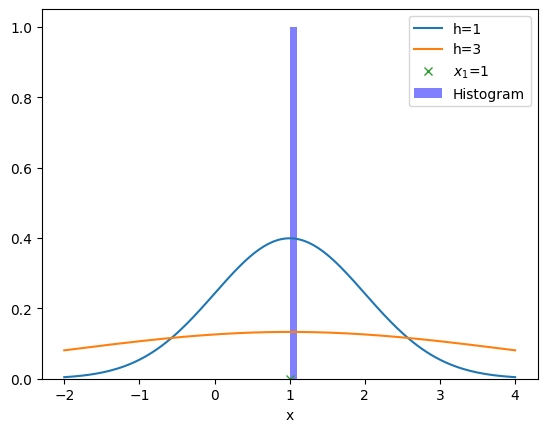

In [16]:
plt.plot(x, kernel_1, label='h=1')
plt.plot(x, kernel_2, label='h=3')
plt.plot(s, 0, 'x', label="$x_{1}$=1")
plt.hist(s, 10, facecolor='blue', alpha=0.5, label="Histogram")
plt.xlabel('x')
plt.legend()
plt.show()

We see that for x close to our sample point ($x_{1}$ = 1), the gaussian kernel function returns larger values; for x far away from $x_{1}$, the kernel function gives smaller values that are approaching 0.


For many samples the  KDE is given by:


 ${\hat {f}}_{h}(x)={\frac {1}{n h^{D}}}\sum _{i=1}^{n}K_{h}(\boldsymbol{x}-\boldsymbol{x}_{i})$


In Python, we generate the KDE with bandwith $h$ for set of point $x_i$, stored in the NumPy array <code>S</code>, in the range of $x$ as follows:


In [17]:
def kernel_density(S, x, h=1):

    density = np.zeros((200))
    for s in S:
        #Determine the distance and kernel for each point 
        dist = np.sqrt(((x - s) ** 2))
        kernel = gaussian(dist, h)
        #Find the sum  
        density += kernel
    #Normalize the sum  
    density = density / density.sum() 
    
    return density

Consider the following data points:  


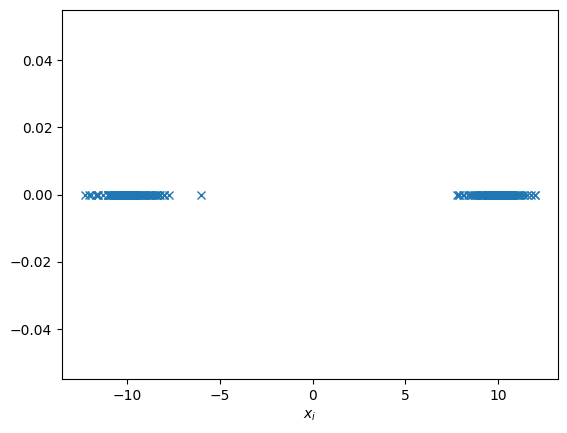

In [18]:
S = np.zeros((200))
S[0: 100] = np.random.normal(-10, 1, 100)
S[100: 200] = np.random.normal(10, 1, 100)
plt.plot(S,np.zeros((200)), 'x')
plt.xlabel("$x_{i}$")
plt.show()

We can generate the density in a specified region $x$.


In [19]:
x = np.linspace(S.min()-3, S.max()+3, num=200)
density = kernel_density(S, x)

We can plot the results along with clusters locations. They should correspond to the two peaks of the distribution.   


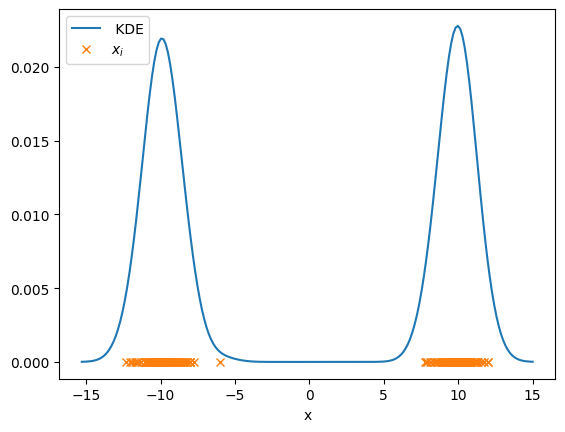

In [22]:
plt.plot(x, density, label=" KDE")
plt.plot(S, np.zeros((200,1)), 'x', label="$x_{i}$")
plt.xlabel('x')
plt.legend()
plt.show()

To find the two maximums we can apply the Gradient Ascent to each vector  $\{\boldsymbol{x}_{1},..,\boldsymbol{x}_{n}\}$:


$ \boldsymbol{\hat{x}}^{k+1}_i := \boldsymbol{\hat{x}}^{k}_i + \eta \nabla {\hat {f}}_{h}(\boldsymbol{\hat{x}}^{k}_i) $


For example, we set for $\boldsymbol{\hat{x}}^{0}_{1}=\boldsymbol{x}_1$, then apply:


$ \boldsymbol{\hat{x}}^{k+1}_1 := \boldsymbol{\hat{x}}^{k}_1 + \eta \nabla {\hat {f}}_{h}(\boldsymbol{\hat{x}}^{k}_1) $


 for $\boldsymbol{\hat{x}}^{0}_{2}=\boldsymbol{x}_2$, then apply:


$ \boldsymbol{\hat{x}}^{k+1}_2 := \boldsymbol{\hat{x}}^{k}_2 + \eta \nabla {\hat {f}}_{h}(\boldsymbol{\hat{x}}^{k}_2) $


Mean Shift is an alternative method for selecting a good value for $\eta$ and $h$ , so that each $ \boldsymbol{\hat{x}}^{k+1}_i$ should approach the two maximums.


<h3>Mean Shift From Scratch  </h3>


In order to find the peak of the distribution, we calculate the gradient. The mean shift vector is proportional to the gradient and always points toward the direction of the maximum increase in density. The expression for the mean shift is shown here along with the Python code: 


 $\nabla  {\hat {f}}_{h}(\boldsymbol{x}) \varpropto\ \boldsymbol{m}_h(\boldsymbol{x})=\frac{ \sum_{i} K'(\boldsymbol{x}_i - \boldsymbol{x}) \boldsymbol{x}_i } {\sum_{i} K'(\boldsymbol{x}_i - \boldsymbol{x})}-\boldsymbol{x} $


 where $K'$ is the derivative of the kernel,  we can output the mean shift values for <code>S</code> as follows:


In [23]:
mean_shift = ((density.reshape(-1, 1) * S).sum(0) / density.sum()) - x

If we overlay the mean shift value over the distribution, $\boldsymbol{m}_h(\boldsymbol{x})$, we will see that vectors point towards the two peaks.


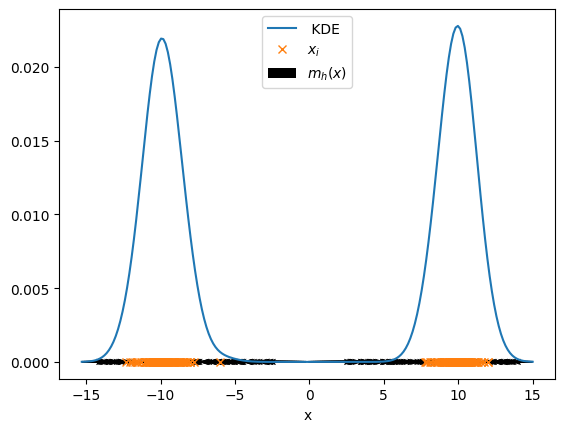

In [24]:
plt.plot(x, density, label=" KDE")
plt.plot(S, np.zeros((200, 1)), 'x', label="$x_{i}$")
plt.quiver(x, np.zeros((200, 1)), mean_shift, np.zeros((200, 1)), units='width', label="$m_{h}(x)$")
plt.xlabel('x')
plt.legend()
plt.show()

By plugging in the value of  the mean shift vector into the expression  for gradient ascent, we get:


$ \boldsymbol{\hat{x}}^{k+1}_i := \boldsymbol{\hat{x}}^{k}_i + \eta \nabla {\hat {f}}_{h}(\boldsymbol{\hat{x}}^{k}_i) \approx\boldsymbol{x}^{k}_i +  \boldsymbol{m}_h(\boldsymbol{\hat{x}}^{k}_i)$


$ \boldsymbol{\hat{x}}^{k+1}_i := \boldsymbol{\hat{x}}^{k}_i +\frac{ \sum_{i} K(\boldsymbol{x}_i -\boldsymbol{\hat{x}}^{k}_i) \boldsymbol{x}_i } {\sum_{i} K(\boldsymbol{x}_i - \boldsymbol{\hat{x}}^{k}_i)}-\boldsymbol{\hat{x}}^{k}_i$


$ \boldsymbol{\hat{x}}^{k+1}_i := \frac{ \sum_{i} K(\boldsymbol{x}_i -\boldsymbol{\hat{x}}^{k}_i) \boldsymbol{x}_i } {\sum_{i} K(\boldsymbol{x}_i - \boldsymbol{\hat{x}}^{k}_i)}$


We can run the algorithm  for three iterations, each point should converge to the cluster centers :


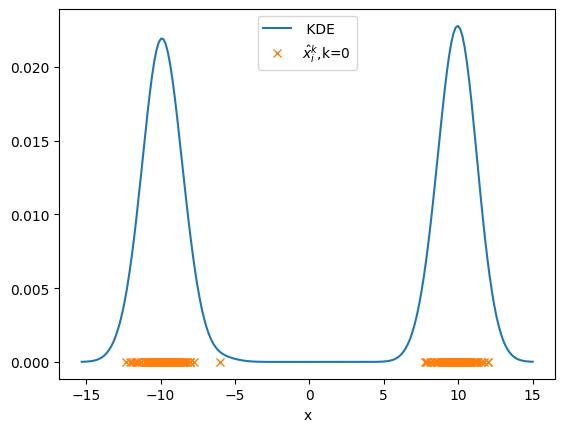

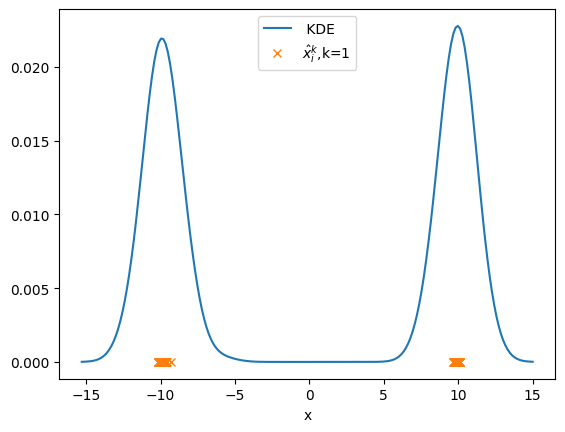

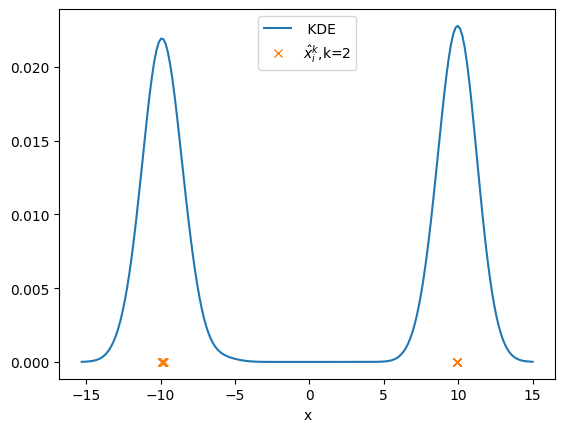

In [25]:
Xhat = np.copy(S.reshape(-1, 1))
S_ = S.reshape(-1, 1)


for k in range(3):
    plt.plot(x, density, label=" KDE")
    plt.plot(Xhat, np.zeros((200, 1)), 'x', label="$\hat{x}^{k}_i$,k="+str(k))
    plt.xlabel('x')
    plt.legend()
    plt.show()
  
    for i, xhat in enumerate(Xhat):
        dist = np.sqrt(((xhat-S_) ** 2).sum(1))
        weight = gaussian(dist, 2.5)
        Xhat[i] = (weight.reshape(-1, 1) * S_).sum(0) / weight.sum()
    